# Phase estimation with QCNN

## Transverse field
---
Implement Variational Quantum Eigensolver algorithm for the system:
$$ H = \lambda \sum_{i}^{N} \sigma_z^i - \sum_{i}^{N-1} \sigma_{x}^{i+1}\sigma_x^i $$

where:
$$
\begin{align}
\sigma_z^i &= \mathbb{I}\otimes\mathbb{I}\otimes ... \otimes \mathbb{I}\otimes \begin{pmatrix}1 & 0 \\ 0 & -1 \end{pmatrix} \otimes \mathbb{I}\otimes ... \otimes \mathbb{I} \\
\sigma_x^i &= \mathbb{I}\otimes\mathbb{I}\otimes ... \otimes \mathbb{I}\otimes \begin{pmatrix}0 & 1 \\ 1 & 0 \end{pmatrix} \otimes \mathbb{I}\otimes ... \otimes \mathbb{I} \\
\end{align}
$$
Then train a Quantum Convolutional Neural Network.

Reproducing results from: https://arxiv.org/abs/1906.10155

In [1]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

# Plotting
from matplotlib import pyplot as plt

# Other
import copy
from tqdm.notebook import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading
##############


In [2]:
N = 4

In [3]:
dev_vqe = qml.device('default.mixed', wires=N, shots = None)

## States preparation through VQE

***Goal:*** Find the (lowest) upper-bound of the lowest <em>eigenvalue</em> (the <em>Ground-State</em>) of a given Hamiltonian.

$$\begin{align}
H \left|\psi\right> &= \lambda \left|\psi\right>\\
& \\
\left<\psi\right| H \left|\psi\right> &= \lambda \left<\psi\right|\left.\psi\right>\\
&\\
\frac{ \left<\psi\right| H \left|\psi\right> }{ \left<\psi\right|\left.\psi\right> } &= \lambda \equiv E_\lambda
\end{align}$$

***Algorithm***:
* 1\. Choose an Ansatz for initial $\left|\psi\right>$
* 2\. Initialize circuit with starting parameters $\vec{\theta_0}$
* 3\. For iteration in iterations
    * 3.1\. Pass $\left|\psi\right>$ through the $circuit(\vec{\theta})\,\,\to\,\,\left|\psi(\theta)\right>$
    * 3.2\. Compute $\left<\psi(\theta)\right|H\left|\psi(\theta)\right>$ (assuming normalization)
    * 3.3\. Update parameters $\theta$ to minimize $\left<\psi(\theta)\right|H\left|\psi(\theta)\right>$
    
    
<img src="https://qiskit.org/textbook/ch-applications/images/U3_var_form.png" alt="circ" width="500"> 


***Circuit***:

<img src="./imgs/ansatz.svg" alt="ansatz" width="1000"/>

In [5]:
###################
## VQE FUNCTIONS ##
###################

def qml_build_H(N, lam, J):
    '''
    Set up Hamiltonian: 
            H = lam*Σsigma^i_z - J*Σsigma^i_x*sigma^{i+1}_ 
    '''
    # Interaction of spins with magnetic field
    H = lam * qml.PauliZ(0)
    for i in range(1,N):
        H = H + lam * qml.PauliZ(i)
        
    # Interaction between spins:
    for i in range(0,N-1):
        H = H + J*(-1)*( qml.PauliX(i) @ qml.PauliX(i+1) )
    
    return H

def vqe_circuit_block_1(N, param, shift_invariance = 0, index = 0, p_noise = 0):
    '''
    RX + RY + CNOTS
    
    shift_invariance = 0: Each wire permorms independent rotations.
    shift_invariance = 1: Same rotation for odd and even wires,
                         expect for the first and last that have unique
                         rotation.
    shift_invariance = 2: Same rotation for each wire
    '''
    if shift_invariance == 0: # Independent rotations
        # Apply RX and RY to each wire:
        for spin in range(N):
            qml.RY(param[index + spin],     wires = spin)
            qml.PhaseFlip(p_noise, wires = spin)
            qml.BitFlip(p_noise, wires = spin)
            qml.RX(param[index + N + spin], wires = spin)
            qml.PhaseFlip(p_noise, wires = spin)
            qml.BitFlip(p_noise, wires = spin)
        return index + 2*N
        
    elif shift_invariance == 1: # RX and RY rotations
        # Apply RX + RY for first wire
        qml.RY(param[index + 0], wires = 0)
        qml.PhaseFlip(p_noise, wires = 0)
        qml.BitFlip(p_noise, wires = 0)
        qml.RX(param[index + 1], wires = 0)
        qml.PhaseFlip(p_noise, wires = 0)
        qml.BitFlip(p_noise, wires = 0)
        
        # Apply RX + RY for last wire
        qml.RY(param[index + 2], wires = N - 1)
        qml.PhaseFlip(p_noise, wires = N - 1)
        qml.BitFlip(p_noise, wires = N - 1)
        qml.RX(param[index + 3], wires = N - 1)
        qml.PhaseFlip(p_noise, wires = N - 1)
        qml.BitFlip(p_noise, wires = N - 1)

        # Apply RX + RY for even and odd wires
        for spin in range(1,N-1,2):
            qml.RY(param[index + 4], wires = spin)
            qml.RY(param[index + 5], wires = spin+1)
            qml.PhaseFlip(p_noise, wires = spin)
            qml.BitFlip(p_noise, wires = spin)
            qml.PhaseFlip(p_noise, wires = spin+1)
            qml.BitFlip(p_noise, wires = spin+1)
            qml.RX(param[index + 6], wires = spin)
            qml.RX(param[index + 7], wires = spin+1)
            qml.PhaseFlip(p_noise, wires = spin)
            qml.BitFlip(p_noise, wires = spin)
            qml.PhaseFlip(p_noise, wires = spin+1)
            qml.BitFlip(p_noise, wires = spin+1)
        
        return index + 8
    
    elif shift_invariance == 2:
        # Apply same RX and RY to each wire:
        for spin in range(N):
            qml.RY(param[index + 0], wires = spin)
            qml.PhaseFlip(p_noise, wires = spin)
            qml.BitFlip(p_noise, wires = spin)
            qml.RX(param[index + 1], wires = spin)
            qml.PhaseFlip(p_noise, wires = spin)
            qml.BitFlip(p_noise, wires = spin)
            
        return index + 2
    
    else:
        raise ValueError('Invalid shift_invariance input value')
        
def vqe_circuit_block_2(N, param, shift_invariance = 0, index = 0, p_noise = 0):
    '''
    RY
    
    shift_invariance = 0: Each wire permorms independent rotations.
    shift_invariance = 1: Same rotation for odd and even wires,
                         expect for the first and last that have unique
                         rotation.
    shift_invariance = 2: Same rotation for each wire
    '''
    if shift_invariance == 0: # Independent rotations
        # Apply RX and RY to each wire:
        for spin in range(N):
            qml.RY(param[index + spin],   wires = spin)
            qml.PhaseFlip(p_noise, wires = spin)
            qml.BitFlip(p_noise, wires = spin)
            
    elif shift_invariance == 1: # RX and RY rotations
        # Apply RY for first wire
        qml.RY(param[index + 0], wires = 0)
        qml.PhaseFlip(p_noise, wires = 0)
        qml.BitFlip(p_noise, wires = 0)

        # Apply RY for last wire
        qml.RY(param[index + 1], wires = N - 1)
        qml.PhaseFlip(p_noise, wires = N - 1)
        qml.BitFlip(p_noise, wires = N - 1)

        # Apply RY for even and odd wires
        for spin in range(1,N-1,2):
            qml.RY(param[index + 2], wires = spin)
            qml.PhaseFlip(p_noise, wires = spin)
            qml.BitFlip(p_noise, wires = spin)
            qml.RY(param[index + 3], wires = spin+1)
            qml.PhaseFlip(p_noise, wires = spin+1)
            qml.BitFlip(p_noise, wires = spin+1)
        
    elif shift_invariance == 2:
        # Apply same RX and RY to each wire:
        for spin in range(N):
            qml.RY(param[index + 0], wires = spin)
            qml.PhaseFlip(p_noise, wires = spin)
            qml.BitFlip(p_noise, wires = spin)
         
    else:
        raise ValueError('Invalid shift_invariance input value')

def vqe_circuit_entanglement(N, p_noise_ent = 0):
    # Apply entanglement to the neighbouring spins
    for spin in range(0,N-1):
        qml.CNOT(wires = [spin, spin+1])
        qml.PhaseFlip(p_noise_ent, wires = spin+1)
        qml.BitFlip(p_noise_ent, wires = spin+1)

@qml.qnode(dev_vqe)
def vqe_cost_fn(vqe_params, N, shift_invariance, H, p_noise = 0.01, p_noise_ent = 0.01):
    vqe_circuit(N, vqe_params, shift_invariance, p_noise, p_noise_ent)
        
    # return <psi|H|psi>
    return qml.expval(H)

def train_vqe_ising(step_size, l_steps, n_epochs, N, shift_invariance, J, dev, circuit = False, plots = False, first_epochs = False):
    '''
    step_size    = Step size of the optimizer
    first_epochs = # epochs for first lambda (magnetic field)
    n_epochs     = # epochs for the other lambdas
    lams         = Array of intensities of magnetic field
    N            = Number of spins of the system
    '''
    
    display(Markdown('***Parameters:***'))
    print('step_size    = {0} (Step size of the optimizer)'.format(step_size))
    print('first_epochs = {0} (# epochs for first GS)'.format(first_epochs))
    print('n_epochs     = {0} (# epochs for the other GSs'.format(n_epochs))
    print('N            = {0} (Number of spins of the system)'.format(N))
    
    # Build array of magnetic field intensities:
    # lams in [0, 2*J]
    lams = np.linspace(0,2*J,l_steps)
    
    # Array of energies for each final ground state found
    vqe_e = []
    errs = np.zeros((n_epochs, len(lams)) )
    
    # Since in order to find the other thetas we start from the optimized parameters of
    # the previous state, to reach a minimum, a less number of parameters is required
    if not first_epochs:
        first_epoch = n_epochs
    
    # Prepare initial state randomly
    if shift_invariance == 0:
        thetas = np.array(np.random.randn(6*N), requires_grad = True)
    elif shift_invariance == 1:
        thetas = np.array(np.random.randn(20),  requires_grad = True)
    elif shift_invariance == 2:
        thetas = np.array(np.random.randn(5),   requires_grad = True)
        
    if circuit:
        # Display the circuit
        display(Markdown('***Circuit:***'))
        drawer = qml.draw(vqe_cost_fn)
        print(drawer(thetas, N, shift_invariance, H = qml_build_H(N, 0 ,0)))
    
    thetas_arr = []
    ys = [] # Labels of the phase
    
    for i, l in enumerate(tqdm(lams)):
        opt = qml.AdamOptimizer(stepsize=step_size)
        H = qml_build_H(N, float(l), J)
        
        # Compute GS-energy by taking the lowest Eigenvalue from the known matrix
        GS_H = np.min(qml.eigvals(H))
        
        epochs = first_epochs if i == 0 else n_epochs
        
        cost_fn = lambda v: vqe_cost_fn(v, N, shift_invariance, H)
        
        for epoch in range(epochs):
            # Compute <H>, then update thetas
            thetas, prev_energy = opt.step_and_cost(cost_fn, thetas)
            # Store the MSE of the current (epoch, lambda)-pair
            if i != 0:
                if epoch < n_epochs:
                    errs[epoch-1, i] = (prev_energy - GS_H)**2
            
        vqe_e.append(cost_fn(thetas))
        thetas_arr.append(thetas)

        ys.append(0) if l <= J else ys.append(1)
        
    if plots:
        fig, ax = plt.subplots(3, 1, figsize=(10,10))

        true_e = []
        for l in lams:
            H = qml_build_H(N, float(l), J)
            true_e.append(np.min(qml.eigvals(H)) )
            
        ax[0].plot(lams, true_e, '--', label='True', color='red', lw = 2)
        ax[0].plot(lams, vqe_e, '.', label='VQE', color='green', lw = 2)
        ax[0].plot(lams, vqe_e, color='green', lw = 2, alpha=0.6)
        ax[0].grid(True)
        ax[0].set_title('Ground States of Ising Hamiltonian ({0}-spins), J = {1}'.format(N,J))
        ax[0].set_xlabel(r'$\lambda$')
        ax[0].set_ylabel(r'$E(\lambda)$')
        ax[0].legend()

        ax[1].plot(range(epochs), np.mean(errs, axis=1), '.', color='orange', ms = 7 )
        ax[1].plot(range(epochs), np.mean(errs, axis=1), color='orange', alpha=0.4)
        ax[1].set_title('Convergence of VQE')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('MSE')
        ax[1].grid(True)
        ax[1].axhline(y=0, color='r', linestyle='--')
        
        true_e = np.array(true_e)
        vqe_e = np.array(vqe_e)
        accuracy = np.abs((true_e-vqe_e)/true_e)
        ax[2].fill_between(lams, 0.01, max(np.max(accuracy),0.01), color = 'r', alpha = 0.3 )
        ax[2].fill_between(lams, .01, min(np.min(accuracy),0), color = 'green', alpha = 0.3 )
        ax[2].axhline(y=0.01, color='r', linestyle='--')
        ax[2].scatter(lams, accuracy)
        ax[2].grid(True)
        ax[2].set_title('Accuracy of VQE'.format(N,J))
        ax[2].set_xlabel(r'$\lambda$')
        ax[2].set_ylabel(r'$|(E_{vqe} - E_{true})/E_{true}|$')
        ax[2].legend()
        
        plt.tight_layout()
        plt.show()
        
         
        
    return vqe_e, errs, thetas_arr, ys      


***Parameters:***

step_size    = 0.3 (Step size of the optimizer)
first_epochs = 100 (# epochs for first GS)
n_epochs     = 50 (# epochs for the other GSs
N            = 4 (Number of spins of the system)


***Circuit:***

0: ──RY(0.10)───PhaseFlip(0.01)──BitFlip(0.01)──RX(-0.92)──PhaseFlip(0.01)──BitFlip(0.01)─╭C
1: ──RY(-1.28)──PhaseFlip(0.01)──BitFlip(0.01)──RX(0.08)───PhaseFlip(0.01)──BitFlip(0.01)─╰X
2: ──RY(-0.20)──PhaseFlip(0.01)──BitFlip(0.01)──RX(1.17)───PhaseFlip(0.01)──BitFlip(0.01)───
3: ──RY(1.50)───PhaseFlip(0.01)──BitFlip(0.01)──RX(-0.70)──PhaseFlip(0.01)──BitFlip(0.01)───

────────────────────────────────────────────────────────────────────────────────────────
───PhaseFlip(0.01)──BitFlip(0.01)─╭C────────────────────────────────────────────────────
──────────────────────────────────╰X──PhaseFlip(0.01)──BitFlip(0.01)─╭C─────────────────
─────────────────────────────────────────────────────────────────────╰X──PhaseFlip(0.01)

──────────────────||──RY(-0.90)──PhaseFlip(0.01)──BitFlip(0.01)──RX(0.30)───PhaseFlip(0.01)
──────────────────||──RY(0.25)───PhaseFlip(0.01)──BitFlip(0.01)──RX(-0.03)──PhaseFlip(0.01)
──────────────────||──RY(-1.29)──PhaseFlip(0.01)──BitFlip(0.01)──RX(-1.23)──PhaseFlip(

  0%|          | 0/10 [00:00<?, ?it/s]

/home/saverio/anaconda3/envs/qua/lib/python3.10/site-packages/pennylane/ops/functions/eigvals.py:104: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


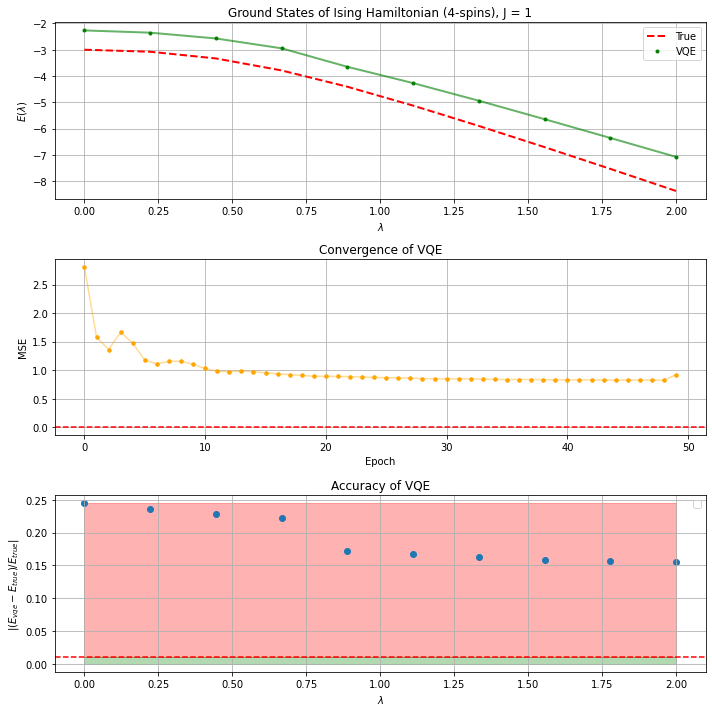

/home/saverio/anaconda3/envs/qua/lib/python3.10/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


['./vqe_circuit_params.job']

In [6]:
vqe_e, errs, thetas, ys = train_vqe_ising(step_size = 0.3, l_steps = 10, n_epochs = 50, N = N, shift_invariance = 0,
                                          J = 1, dev = dev_vqe, circuit = True, plots = True, first_epochs = 100)

vqe_data_x = thetas 
vqe_data_y = ys
    
vqe_data = []
for i in range(len(vqe_data_x)):
    vqe_data.append((vqe_data_x[i],vqe_data_y[i]))
    
vqe_data = np.array(vqe_data)

joblib.dump(vqe_data, './vqe_circuit_params.job')


## Phase estimation through QCNN

Convolution layer:

<img src="./imgs/conv.svg" alt="conv" width="300"/>

Pooling block:

<img src="./imgs/pool.svg" alt="pool" width="500"/>

In [5]:
dev_qcnn = qml.device('default.qubit.jax', wires=N)

In [110]:
# Load data and separate in training and test set
data = joblib.load('./vqe_circuit_params.job')

print('Size of Data Set: {0}'.format(len(data)))

train_index = np.sort(np.random.choice(np.arange(len(data)), size=int(0.8*len(data)), replace=False ))

X_train, Y_train = [], []
X_test, Y_test   = [], []

for i in range(len(data)): 
    if i in train_index:
        X_train.append(data[i][0])
        Y_train.append(data[i][1])
    else:
        X_test.append(data[i][0])
        Y_test.append(data[i][1])
        
#X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
#X_test, Y_test   = jnp.array(X_test), jnp.array(Y_test)

print('______________________________')
print('Size of Training Set: {0}'.format(np.shape(X_train)[0]))
print('Size of Test Set    : {0}'.format(np.shape(X_test)[0]))


Size of Data Set: 100
______________________________
Size of Training Set: 80
Size of Test Set    : 20


In [130]:
####################
## QCNN FUNCTIONS ##
####################

def num_params_qcnn(N):
    '''
    N = number of wires (spins)
    To evaluate the number of parameters needed for the qcnn
    a recursive function is needed:
    '''
    n_params = 0
    # While the number of wires is more than 1s
    while(N > 1):
        # Convolution
        n_params += 3*N
        # Pooling 
        n_params += 2*(N//2) + N%2
        # Reduce number of wires due to pooling
        N = N // 2 + N % 2
    
    # Last RY gate
    n_params += 1
    
    return n_params

def qcnn_convolution(active_wires, params, N, p_index):
    '''
    Convolution block for the QCNN
    '''
    # Check if the current number of wires is odd
    # it will be needed later.
    isodd = True if len(active_wires) % 2 != 0  else False
    
    # Convolution:
    for wire in active_wires:
        qml.RX(params[p_index],   wires = int(wire) )
        qml.RY(params[p_index+1], wires = int(wire) )
        p_index = p_index + 2
        
    # ---- > Establish entanglement: odd connections
    for wire, wire_next in zip(active_wires[0::2], active_wires[1::2]):
        qml.CNOT(wires = [int(wire), int(wire_next)])
        qml.RX(params[p_index], wires = int(wire) )
        p_index = p_index + 1
        
    # ---- > Establish entanglement: even connections
    for wire, wire_next in zip(active_wires[1::2], active_wires[2::2]):
        qml.CNOT(wires = [int(wire), int(wire_next)])
        qml.RX(params[p_index], wires = int(wire) )
        p_index = p_index + 1
    qml.RX(params[p_index], wires = N-1)
    p_index = p_index + 1

    return p_index
        
def qcnn_pooling(active_wires, params, N, p_index):
    '''
    Pooling block for the QCNN
    '''
    # Pooling:
    isodd = True if len(active_wires) % 2 != 0  else False
    for wire_meas, wire_next in zip(active_wires[0::2], active_wires[1::2]):
        m_0 = qml.measure(int(wire_meas) )
        qml.cond(m_0 ==0, qml.RY)(params[p_index], wires=int(wire_next) )
        qml.cond(m_0 ==1, qml.RZ)(params[p_index+1], wires=int(wire_next) )
        p_index = p_index + 1
        # Removing measured wires from active_wires:
        active_wires = np.delete(active_wires, np.where(active_wires == wire_meas) ) 
    # ---- > If the number of wires is odd, the last wires is not pooled
    #        so we apply a Z gate
    if isodd:
        qml.RZ(params[p_index], wires = N-1)
        p_index = p_index + 1
        
    return p_index, active_wires

@qml.qnode(dev_qcnn, interface="jax", diff_method="best")     
def qcnn(params_vqe, vqe_shift_invariance, params, N):
    '''
    Building function for the circuit:
          VQE(params_vqe) + QCNN(params)
    '''
    # Check on the size of the parameters:
    if len(params) != num_params_qcnn(N):
        raise ValueError('Invalid size of parameters')
        
    # Wires that are not measures (through pooling)
    active_wires = np.arange(N)
    
    # Input: State through VQE
    vqe_circuit(N, params_vqe, vqe_shift_invariance)
    
    qml.Barrier()
    
    # Index of the parameter vector
    p_index = 0
    
    while(len(active_wires) > 1):
        p_index = qcnn_convolution(active_wires, params, N, p_index)
        qml.Barrier()
        p_index, active_wires = qcnn_pooling(active_wires, params, N, p_index)
        qml.Barrier()
    
    # Final Y rotation
    qml.RY(params[p_index], wires = N-1)
    
    return qml.probs(wires = N - 1)

# Estimation functions for QCNN
def cross_entropy(labels, predictions):
    '''
    f = - Σ [(Yi*log(Pi) + (1 - Yi)*log(1 - Pi) )]  for i in TrainingSet
    '''
    loss = 0
    for l, p in zip(labels, predictions):
        c_entropy = l * (jnp.log(p[l])) + (1 - l) * jnp.log(1 - p[1 - l])
        loss = loss + c_entropy

    return -1 * loss

def cost_fn(params, X, Y, N, vqe_shift_invariance):
    fn = lambda v: qcnn(v, vqe_shift_invariance, params, N)
    
    # Create a vectorized version of our original circuit.
    vcircuit = jax.vmap(fn)

    predictions = vcircuit(X)
    loss = cross_entropy(Y, predictions)
    
    return loss

def compute_cost(X, Y, params, N, vqe_shift_invariance):
    circuit = lambda v: cost_fn(v, X, Y, N, vqe_shift_invariance)
    
    return circuit(params)

def predict(X, Y, params, N, vqe_shift_invariance):
    '''
    Accuracy = (corretly predicted labels)/(total # of labels) * 100 ( %100) 
    '''
    
    fn = lambda v: qcnn(v, vqe_shift_invariance, params, N)
    # Create a vectorized version of our original circuit.
    vcircuit = jax.vmap(fn)
    
    predictions = vcircuit(X)
    
    return predictions

# Training function
def qcnn_training(X_train, Y_train, X_test = [], Y_test = [], steps = 100, lr0 = 0.001, N = 8, 
                  vqe_shift_invariance = 0, plot = True):
    '''
    lr0          = Initial Learning Rate
    steps        = number of epochs for training
    first_epochs = # epochs for first lambda (magnetic field)
    N            = Number of spins/wires of the system
    '''
    X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
    X_test, Y_test = jnp.array(X_test), jnp.array(Y_test)
    
    display(Markdown('***Parameters:***'))
    print('lr0        = {0} (Initial learning rate)'.format(lr0))
    print('steps      = {0} (# epochs)'.format(steps))
    print('N          = {0} (Number of spins of the system)'.format(N))
    
    # Initialize parameters randomly
    params = jnp.array( np.random.randn(num_params_qcnn(N)) )
    
    loss_history = []
    accuracy_history = []
    #loss_history_test = []
    accuracy_history_test = []
    
    progress = tqdm(range(steps))
    
    lr = lr0
    for epoch in progress:
        lr = lr0*(np.exp(-0.01*epoch))
            
        circuit = lambda v: cost_fn(v, X_train, Y_train, N, vqe_shift_invariance)
        grad_circuit = jax.grad(circuit)
        params -= lr*grad_circuit(params)
        
        if epoch % 10 == 0:
            loss_history.append(compute_cost(X_train, Y_train, params, N, vqe_shift_invariance) )
            pred = predict(X_train, Y_train, params, N, vqe_shift_invariance)
            acc = 100*(np.sum(jnp.argmax(pred, axis=1) == jnp.asarray(Y_train)) )/jnp.shape(X_train)[0]
            accuracy_history.append(acc)
            
            if len(X_test) > 0:
                pred_test = predict(X_test, Y_test, params, N, vqe_shift_invariance)
                acc_test = 100*(np.sum(jnp.argmax(pred_test, axis=1) == jnp.asarray(Y_test)) )/jnp.shape(X_test)[0]
                accuracy_history_test.append(acc_test)
        
        # Set description to current loss
        progress.set_description('Cost: {0} | Accuracy: {1}'.format(np.round(loss_history[-1],3), accuracy_history[-1]) )
        
    print('Accuracy on Training Set: {0}'.format(compute_accuracy(X_train, Y_train, params, N, vqe_shift_invariance) ) )

    if plot:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(len(loss_history))*10, np.asarray(loss_history), label = 'Training Loss')
       #if len(X_test) > 0:
            #plt.plot(np.arange(steps), np.asarray(loss_history_test)/len(X_test), color = 'green', label = 'Test Loss')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Loss history')
        plt.ylabel('Average Cross entropy')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()
        
        plt.figure(figsize=(15,4))
        plt.plot(np.arange(len(accuracy_history))*10, accuracy_history, color='orange', label = 'Training Accuracy')
        if len(X_test) > 0:
            plt.plot(np.arange(len(accuracy_history))*10, accuracy_history_test, color='violet', label = 'Test Accuracy')
        plt.axhline(y=100, color='r', linestyle='--')
        plt.title('Accuracy')
        plt.ylabel('%')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()
        
    return loss_history, accuracy_history, params

def plot_results_classification(data, train_index, params, N, vqe_shift_invariance):
    test_index = []
    for i in range(len(data)):
        if not i in train_index:
            test_index.append(i)
    
    predictions_train = []
    predictions_test  = []

    colors_train = []
    colors_test  = []

    for i in range(len(data)):
        prediction = qcnn(data[i][0], vqe_shift_invariance, params,N)[1]

        # if data in training set
        if i in train_index:
            predictions_train.append(prediction)
            if np.round(prediction) == 0:
                if i <= len(data)/2:
                    colors_train.append('green')
                else:
                    colors_train.append('red')
            else:
                if i <= len(data)/2:
                    colors_train.append('red')
                else:
                    colors_train.append('green')
        else:
            predictions_test.append(prediction)
            if np.round(prediction) == 0:
                if i <= len(data)/2:
                    colors_test.append('green')
                else:
                    colors_test.append('red')
            else:
                if i <= len(data)/2:
                    colors_test.append('red')
                else:
                    colors_test.append('green')
    
    fig, ax = plt.subplots(2, 1, figsize=(16,10))

    ax[0].set_xlim(-0.1,2.1)
    ax[0].set_ylim(0,1)
    ax[0].grid(True)
    ax[0].axhline(y=.5, color='gray', linestyle='--')
    ax[0].axvline(x=1, color='gray', linestyle='--')
    ax[0].text(0.375, .68, 'I', fontsize=24, fontfamily='serif')
    ax[0].text(1.6, .68, 'II', fontsize=24, fontfamily='serif')
    ax[0].set_xlabel('Transverse field')
    ax[0].set_ylabel('Prediction of label II')
    ax[0].set_title('Predictions of labels; J = 1')
    ax[0].scatter(2*np.sort(train_index)/len(data), predictions_train, c = 'royalblue', label='Training samples')
    ax[0].scatter(2*np.sort(test_index)/len(data), predictions_test, c = 'orange', label='Test samples')
    ax[0].legend()

    ax[1].set_xlim(-0.1,2.1)
    ax[1].set_ylim(0,1)
    ax[1].grid(True)
    ax[1].axhline(y=.5, color='gray', linestyle='--')
    ax[1].axvline(x=1, color='gray', linestyle='--')
    ax[1].text(0.375, .68, 'I', fontsize=24, fontfamily='serif')
    ax[1].text(1.6, .68, 'II', fontsize=24, fontfamily='serif')
    ax[1].set_xlabel('Transverse field')
    ax[1].set_ylabel('Prediction of label II')
    ax[1].set_title('Predictions of labels; J = 1')
    ax[1].scatter(2*np.sort(train_index)/len(data), predictions_train, c = colors_train)
    ax[1].scatter(2*np.sort(test_index)/len(data), predictions_test, c = colors_test)

In [131]:
drawer = qml.draw(qcnn)
print(drawer([0]*100,0,[0]*num_params_qcnn(N), N))

0: ──RY(0.00)──RX(0.00)─╭C────────────────────||──RY(0.00)──RX(0.00)─╭C────────────────────||
1: ──RY(0.00)──RX(0.00)─╰X─╭C─────────────────||──RY(0.00)──RX(0.00)─╰X─╭C─────────────────||
2: ──RY(0.00)──RX(0.00)────╰X─╭C──────────────||──RY(0.00)──RX(0.00)────╰X─╭C──────────────||
3: ──RY(0.00)──RX(0.00)───────╰X─╭C───────────||──RY(0.00)──RX(0.00)───────╰X─╭C───────────||
4: ──RY(0.00)──RX(0.00)──────────╰X─╭C────────||──RY(0.00)──RX(0.00)──────────╰X─╭C────────||
5: ──RY(0.00)──RX(0.00)─────────────╰X─╭C─────||──RY(0.00)──RX(0.00)─────────────╰X─╭C─────||
6: ──RY(0.00)──RX(0.00)────────────────╰X─╭C──||──RY(0.00)──RX(0.00)────────────────╰X─╭C──||
7: ──RY(0.00)──RX(0.00)───────────────────╰X──||──RY(0.00)──RX(0.00)───────────────────╰X──||

───RY(0.00)──||──RX(0.00)──RY(0.00)─╭C──RX(0.00)───────────────||─╭C────────────────────────
───RY(0.00)──||──RX(0.00)──RY(0.00)─╰X───────────╭C──RX(0.00)──||─╰ControlledOperation(0.00)
───RY(0.00)──||──RX(0.00)──RY(0.00)─╭C──RX(0.00)─╰X──────────

***Parameters:***

lr0        = 0.15 (Initial learning rate)
steps      = 500 (# epochs)
N          = 8 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

accuracy (80, 2)
Accuracy on Training Set: 91.25


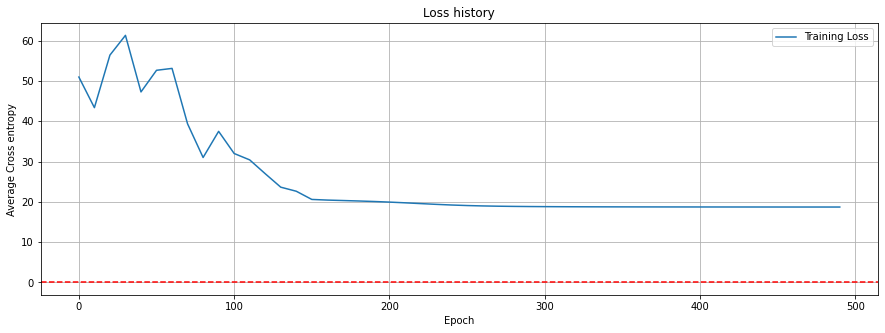

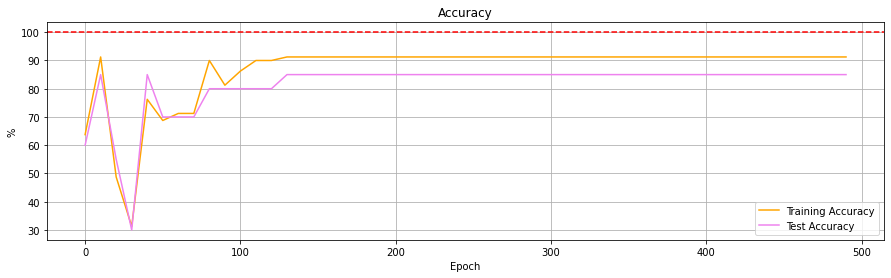

In [132]:
loss_history, accuracy_history, params = qcnn_training(X_train, Y_train, X_test, Y_test, vqe_shift_invariance = 0,
                                                       lr0 = 15e-2, steps = 500)


/home/saverio/anaconda3/envs/qua/lib/python3.10/site-packages/pennylane/math/multi_dispatch.py:65: UserWarning: Contains tensors of types {'autograd', 'jax'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


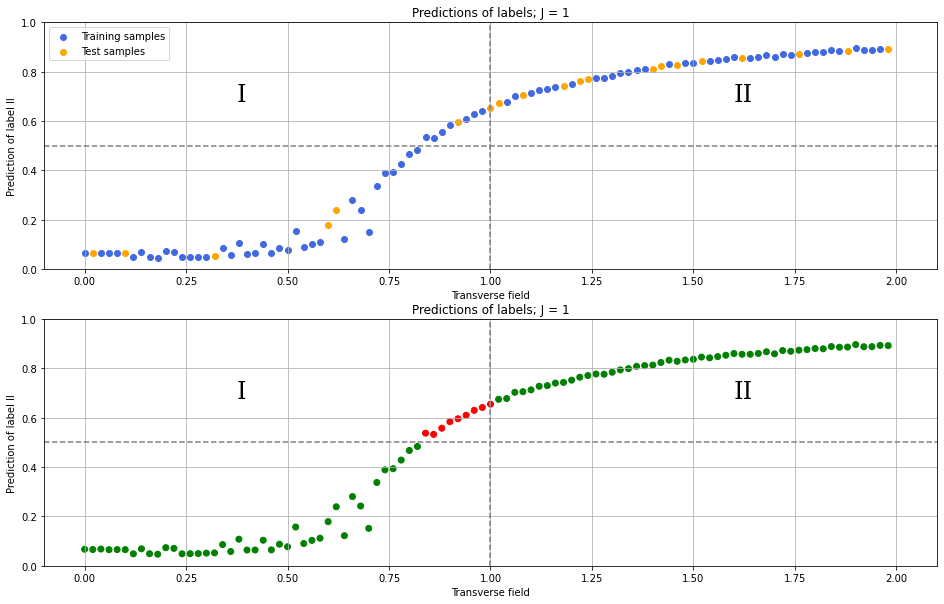

In [114]:
plot_results_classification(data, train_index, params, N, 0)

---
## Backup code

## Backup code 1: Shift-invariant Ansatz

Each rotation layer are 4 parameters:
* 1 for the first wire/spin
* 1 for the even wires
* 1 for the odd wires
* 1 for the last wire/spin

<img src="./imgs/siansatz.svg" alt="ansatz" width="1000"/>

***Parameters:***

step_size    = 0.15 (Step size of the optimizer)
first_epochs = 500 (# epochs for first GS)
n_epochs     = 50 (# epochs for the other GSs
N            = 8 (Number of spins of the system)


***Circuit:***

0: ──RY(-0.81)──RX(0.21)──╭C────────────────────||──RY(1.00)───RX(-1.20)─╭C────────────────────||
1: ──RY(0.37)───RX(1.30)──╰X─╭C─────────────────||──RY(-0.59)──RX(-0.22)─╰X─╭C─────────────────||
2: ──RY(-0.30)──RX(-0.21)────╰X─╭C──────────────||──RY(0.71)───RX(-0.01)────╰X─╭C──────────────||
3: ──RY(0.37)───RX(1.30)────────╰X─╭C───────────||──RY(-0.59)──RX(-0.22)───────╰X─╭C───────────||
4: ──RY(-0.30)──RX(-0.21)──────────╰X─╭C────────||──RY(0.71)───RX(-0.01)──────────╰X─╭C────────||
5: ──RY(0.37)───RX(1.30)──────────────╰X─╭C─────||──RY(-0.59)──RX(-0.22)─────────────╰X─╭C─────||
6: ──RY(-0.30)──RX(-0.21)────────────────╰X─╭C──||──RY(0.71)───RX(-0.01)────────────────╰X─╭C──||
7: ──RY(0.28)───RX(-0.98)───────────────────╰X──||──RY(-0.66)──RX(1.84)────────────────────╰X──||

───RY(-0.13)─┤ ╭<𝓗>
───RY(1.63)──┤ ├<𝓗>
───RY(-0.31)─┤ ├<𝓗>
───RY(1.63)──┤ ├<𝓗>
───RY(-0.31)─┤ ├<𝓗>
───RY(1.63)──┤ ╰<𝓗>
───RY(-0.31)─┤     
───RY(-2.15)─┤     


  0%|          | 0/100 [00:00<?, ?it/s]

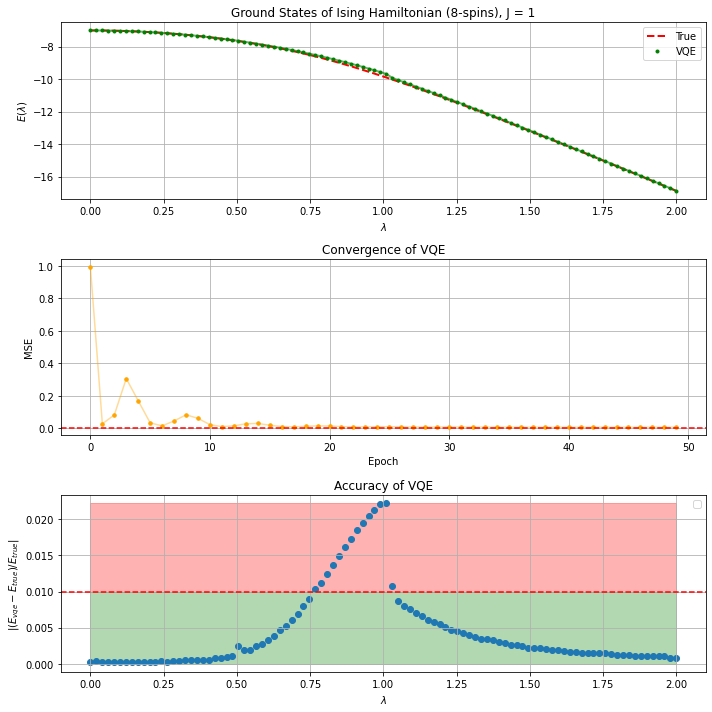

In [117]:
vqe_e, errs, thetas, ys = train_vqe_ising(step_size = 0.15, l_steps = 100, n_epochs = 50, N = N, shift_invariance = 1,
                                          J = 1, dev = dev_vqe, circuit = True, plots = True, first_epochs = 500)

In [ ]:
vqe_e, errs, thetas, ys = train_vqe_ising(step_size = 0.3, l_steps = 100, n_epochs = 50, N = N, shift_invariance = 2,
                                          J = 1, dev = dev_vqe, circuit = True, plots = True, first_epochs = 500)

***Parameters:***

step_size    = 0.3 (Step size of the optimizer)
first_epochs = 500 (# epochs for first GS)
n_epochs     = 50 (# epochs for the other GSs
N            = 8 (Number of spins of the system)


***Circuit:***

0: ──RY(-0.84)──RX(0.64)─╭C────────────────────||──RY(1.88)──RX(0.43)─╭C────────────────────||
1: ──RY(-0.84)──RX(0.64)─╰X─╭C─────────────────||──RY(1.88)──RX(0.43)─╰X─╭C─────────────────||
2: ──RY(-0.84)──RX(0.64)────╰X─╭C──────────────||──RY(1.88)──RX(0.43)────╰X─╭C──────────────||
3: ──RY(-0.84)──RX(0.64)───────╰X─╭C───────────||──RY(1.88)──RX(0.43)───────╰X─╭C───────────||
4: ──RY(-0.84)──RX(0.64)──────────╰X─╭C────────||──RY(1.88)──RX(0.43)──────────╰X─╭C────────||
5: ──RY(-0.84)──RX(0.64)─────────────╰X─╭C─────||──RY(1.88)──RX(0.43)─────────────╰X─╭C─────||
6: ──RY(-0.84)──RX(0.64)────────────────╰X─╭C──||──RY(1.88)──RX(0.43)────────────────╰X─╭C──||
7: ──RY(-0.84)──RX(0.64)───────────────────╰X──||──RY(1.88)──RX(0.43)───────────────────╰X──||

───RY(0.10)─┤ ╭<𝓗>
───RY(0.10)─┤ ├<𝓗>
───RY(0.10)─┤ ├<𝓗>
───RY(0.10)─┤ ├<𝓗>
───RY(0.10)─┤ ├<𝓗>
───RY(0.10)─┤ ╰<𝓗>
───RY(0.10)─┤     
───RY(0.10)─┤     


  0%|          | 0/100 [00:00<?, ?it/s]

---
## Resources
* [Quantum Convolutional Neural Networks](https://arxiv.org/abs/1810.03787)
* [Machine Learning Phase Transitions with a Quantum Processor](https://arxiv.org/abs/1906.10155)